# Air Quality Index of Kizilsu Prefecture 

## Introduction

Kizilsu Kezilesu, an autonomous prefecture in the west of Xinjiang, China is famously know for the signts of Muztagata Peak. The formidable peak stands among snowy mountains on the edge of alphine lake Karkul Lake. During summer and autumn when the mountain air is as fresh as the sights of Muztaga Peak, mountain climbers and tourists visit the base camps and nearby resorts.
![muztaga](images/muztaga.jpg)

However, due to the ongoing urban expansion, more and more people are relocating at the Prefecture for permanent settlement. The air pollution might have inevitably exacerbated.

It is quite interesting to understand how different weather forecast data, such as beaufort force, highest and lowest temperature, come to indicate the air quality index.
## Purpose
Use weather information from June to December of 2018 to graph a decision tree, and observe how Clean and Polluted air quality can be classified by the past weahter forecast(highest and lowest daily temperature, downcast, beaufort wind scale and wind direction)
## Data Preparation - Import from json
Import data from the json file on http://tianqi.2345.com
Give column titles, set date as index, and remove the rows in the aqi column (Air Quality Index) that do not fall within the two standard deviations.

In [38]:
import pandas as pd
import requests
import json
import demjson
import numpy as np
from datetime import datetime, timedelta

def get_dataframe(months):
    """Input strings to complete importing data from json
       Output dataframe organized with columns and index
       outliers removes"""
    # empty list to append dataframe
    frame=[]
    for month in months:
        # link to tainqi.2345.com
        weather = requests.get('http://tianqi.2345.com/t/wea_history/js/{month}/51704_{month}.js'
                    .format(month=month)).text.split('=')[1][:-1]
        # use demjson decode
        weather = demjson.decode(weather)['tqInfo']
        df = pd.DataFrame(weather)
        # remove tailing rows that only have NaN values
        df.drop(df.tail(1).index,inplace=True)
        # column names
        df.columns = ['date','high_temp','low_temp',
                      'weather','wind_direction',
                      'beaufort_force',
                      'aqi','health_index','aqiLevel']
        # set index
        df.set_index("date",inplace=True)
        #df['aqi']=df['aqi'].apply(.astype(float), errors='coerce').dropna()
        #df[~df['aqi'].str.isnumeric()].dropna()
        #pd.to_numeric(df['aqi'],errors='coerce')
        df['aqi']=df['aqi'].astype(float)
        # remove outliers lying outside the 2 std range
        df[np.abs(df.aqi - df.aqi.mean()) <= (2*df.aqi.std())]
        # add a new column to the dataframe
        df['month']=month
        # append dataframe to the frame list
        frame.append(df)
    return pd.concat(frame)

In [39]:
months = ['201806','201807','201808','201809','201810','201811','201812']
df = get_dataframe(months)
df.head()

,high_temp,low_temp,weather,wind_direction,beaufort_force,aqi,health_index,aqiLevel,month
date,,,,,,,,,
2018-06-01,32℃,19℃,多云,无持续风向,微风,68.0,良,2,201806
2018-06-02,32℃,20℃,晴,无持续风向,微风,183.0,中度污染,4,201806
2018-06-03,33℃,21℃,多云,无持续风向,微风,493.0,严重污染,6,201806
2018-06-04,34℃,20℃,晴,西北风,3-4级,293.0,重度污染,5,201806
2018-06-05,33℃,21℃,多云,西北风,1-2级,56.0,良,2,201806


## Data Preparation - Temperature
Remove the degree Celcius and convert to float

In [40]:
def data_temp(df_temp):
    '''
    Input dataframe
    Output dataframe with temperature columns rearranged
    '''
    # Temperature, remove degree Celcius symbol
    df_temp['high_temp'] = df_temp['high_temp'].str.split('℃').str[0]
    df_temp['low_temp'] = df_temp['low_temp'].str.split('℃').str[0]
    # convert to float
    df_temp['high_temp'] = df_temp['high_temp'].astype(float)
    df_temp['low_temp'] = df_temp['low_temp'].astype(float)
    return df_temp

## Data Preparation - Beaufort Force Level
Map each wind level to its respective beaufort force level.
![beaufort force](images/beaufort_force.png)

In [41]:
def data_beaufort(df_beaufort):
    '''
    Input dataframe
    Output dataframe with beaufot force column rearranged
    '''
    # split and replace string values
    df_beaufort['beaufort_force'] = df_beaufort['beaufort_force'].str.split('级').str[0]
    df_beaufort['beaufort_force'] = df_beaufort['beaufort_force'].str.replace('\d'+'-','')
    # dictionary of beaufort force levels
    d_beaufort = {'无风':0, '软风':1, '轻风':2, '微风':3, '和风':4,
                  '劲风':5, '强风':6, '疾风':7, '大风':8, 
                  '烈风':9, '狂风':10, '暴风':11, '飓风':12}
    # lambda to change string to dictionary value
    df_beaufort['beaufort_force'] = df_beaufort['beaufort_force'].apply(lambda x: next((v for k, v in d_beaufort.items()
                                                                      if x in k), x))
    df_beaufort['beaufort_force'] = df_beaufort['beaufort_force'].astype(int)
    return df_beaufort

## Data Preparation - Wind Direction
Map each wind direction to an integer digit.
![wind_direction](images/direction.jpg)

In [42]:
def data_direction (df_direction):
    '''
    Input dataframe
    Output dataframe with wind direction column rearranged
    '''
    # dictionary with string value for each wind direction
    d_direction = {'北风':'north','东北风':'northeast',
                   '东风':'east','东南风':'southeast',
                   '南风':'south','西南风':'southwest',
                   '西风':'west','西北风':'northwest',}
    # lambda to change each direction value
    df_direction['wind_direction'] = df_direction['wind_direction'].apply(lambda x: next((v for k, v in d_direction.items() 
                                                                                          if x in k), 'inconsistent'))
    # dictionary with string value for each wind direction
    int_direction = {'north':1, 'northeast':2, 
                     'east':3, 'southeast':4, 
                     'south':5,'southwest':6, 
                     'west':7, 'northwest':8}
    # lambda to change each direction value to its respective integer
    df_direction['wind_direction'] = df_direction['wind_direction'].apply(lambda x: next((v for k, v in int_direction.items() 
                                                                                          if x in k), 0))
    return df_direction

## Data Preparation - Downcast
The weather column often indicates how the weather of particular date chages through out the day.The dates that already have the hazy weather for bad air quality are removed.
Each row of weather column is updated to indcate levels of downcast:  
    0 for weahter without downcast: sunny, partly cloudy, etc.
    1 to 6 for weahter with downcast: shower, rain, etc.
![dowoncast](images/downcast.png)

In [43]:
def data_weather(df_weather):
    '''
    Input dataframe
    Output dataframe with weather column rearranged
    '''
    # weather column splits at the '~' into two columns
    new = df_weather['weather'].str.split("~",n = 1,expand = True)
    df_weather['weather_1']=new[0].astype(str)
    df_weather['weather_2']=new[1].astype(str)
    
    # fill in NaN rows
    df_weather.fillna(value=pd.np.nan, inplace=True)
    
    # dictionary to indicate downcast
    d_weather ={'晴':'sunny',
                '多云':'partly cloudy','阴':'cloudy', 
                '小雨':'light rain','阵雨':'shower',
                '小到中雨':'light to moderate rain','中雨':'moderate rain',
                '阵雪':'snow shower', '小雪':'light snow',
                '浮尘':'haze'}
    int_weather = {'sunny':0,
                   'partly cloudy':0,'cloudy':0,
                   'shower':1, 'light rain':2, 'light to moderate rain':3,'moderate rain':4,
                   'snow shower':5, 'light snow':6}
    df_weather['weather_1'] = df_weather['weather_1'].apply(lambda x: next((v for k, v in d_weather.items()
                                                                            if x in k), 'unidentified'))
    df_weather['weather_2'] = df_weather['weather_2'].apply(lambda x: next((v for k, v in d_weather.items()
                                                                            if x in k), 'unidentified'))
    # remove weather haze from columns
    df_weather = df_weather.drop(df_weather[(df_weather['weather_1'] == 'haze')].index)
    df_weather = df_weather.drop(df_weather[(df_weather['weather_2'] == 'haze')].index)

    df_weather['weather_1'] = df_weather['weather_1'].apply(lambda x: next((v for k, v in int_weather.items()
                                                                            if x in k), None))
    df_weather['weather_2'] = df_weather['weather_2'].apply(lambda x: next((v for k, v in int_weather.items()
                                                                            if x in k), None))
    # retain the rows with higher integer
    for index in df_weather.index:
        if (df_weather['weather_1'][index] <= df_weather['weather_2'][index]):
            df_weather['weather_1'][index] = df_weather['weather_2'][index]
    # rename column weather_1
    df_weather.rename(columns = {'weather_1': 'downcast'}, inplace = True)
    return df_weather

## Data Preparation - Air Quality Index
Label each air quality index value below or above 100 as 0 or 1 to indicate clean or polluted, respectively.
![aqi](images/aqi.png)

In [44]:
def data_aqi(df_aqi):
    '''
    Input dataframe
    Output dataframe with aqi column rearranged
    '''
    d_aqi = {range(0,51):0, range(50,101):0,
             range(100,151):1, range(150,201):1,
             range(200,301):1, range(300,600):1}
    df_aqi['health_index'] = df_aqi['aqi'].apply(lambda x: next((v for k, v in d_aqi.items()
                                                                 if x in k), 0))
    return df_aqi

Apply the data preparation methods (data_temp, data_beaufort, data_direction, etc)

In [45]:
# form a copy of the dataframe df
df2018 = df.copy()
df2018 = data_temp(df2018)
df2018 = data_beaufort(df2018)
df2018 = data_direction(df2018)
df2018 = data_weather(df2018)
df2018 = data_aqi(df2018)
df2018.head()

C:\Users\m072290\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
C:\Users\m072290\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,high_temp,low_temp,weather,wind_direction,beaufort_force,aqi,health_index,aqiLevel,month,downcast,weather_2
date,,,,,,,,,,,
2018-06-01,32.0,19.0,多云,0,3,68.0,0,2,201806,0,NaN
2018-06-02,32.0,20.0,晴,0,3,183.0,1,4,201806,0,NaN
2018-06-03,33.0,21.0,多云,0,3,493.0,1,6,201806,0,NaN
2018-06-04,34.0,20.0,晴,8,4,293.0,1,5,201806,0,NaN
2018-06-05,33.0,21.0,多云,8,2,56.0,0,2,201806,0,NaN


## AQI of Each Month
The health_index column is the result column vector to the feature matrix consisting of columns for high_temp, low_temp, down_cast, beaufort_force and wind direction. 
A quick look at the AQI data of each day for six months from June to December, 2018.

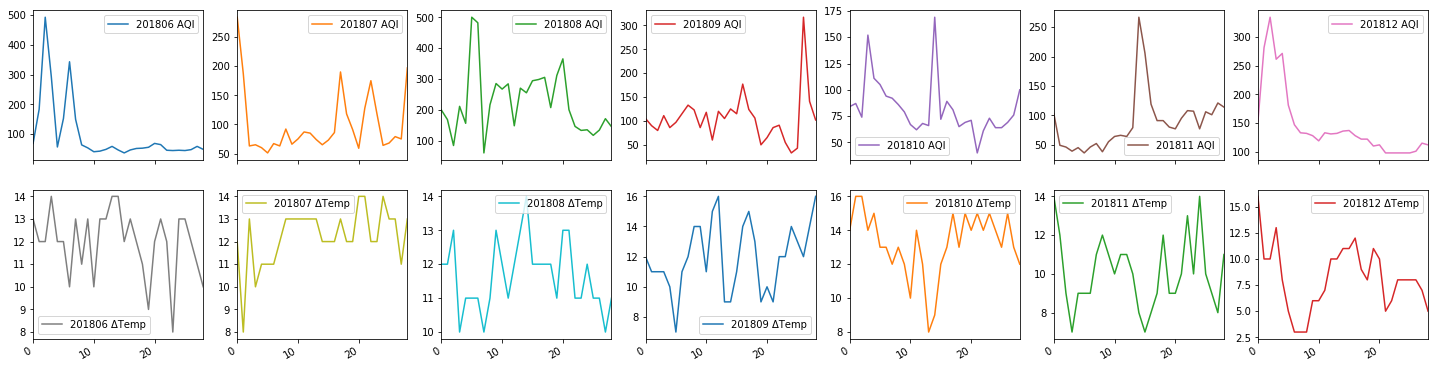

In [46]:
# form a new dataframe df_new to observe the aqi result values
%matplotlib inline
import matplotlib.pyplot as plt

df06 = df2018.loc[df2018['month']=='201806'].reset_index()
df06['temp_diff'] = df06['high_temp'] - df06['low_temp']
listA6 = list(df06['aqi'])
listD6 = list(df06['temp_diff'])

df07 = df2018.loc[df2018['month']=='201807'].reset_index()
df07['temp_diff'] = df07['high_temp'] - df07['low_temp']
listA7 = list(df07['aqi'])
listD7 = list(df07['temp_diff'])

df08 = df2018.loc[df2018['month']=='201808'].reset_index()
df08['temp_diff'] = df08['high_temp'] - df08['low_temp']
listA8 = list(df08['aqi'])
listD8 = list(df08['temp_diff'])

df09 = df2018.loc[df2018['month']=='201809'].reset_index()
df09['temp_diff'] = df09['high_temp'] - df09['low_temp']
listA9 = list(df09['aqi'])
listD9 = list(df09['temp_diff'])

df10 = df2018.loc[df2018['month']=='201810'].reset_index()
df10['temp_diff'] = df10['high_temp'] - df10['low_temp']
listA10 = list(df10['aqi'])
listD10 = list(df10['temp_diff'])

df11 = df2018.loc[df2018['month']=='201811'].reset_index()
df11['temp_diff'] = df11['high_temp'] - df11['low_temp']
listA11 = list(df11['aqi'])
listD11 = list(df11['temp_diff'])

df12 = df2018.loc[df2018['month']=='201812'].reset_index()
df12['temp_diff'] = df12['high_temp'] - df12['low_temp']
listA12 = list(df12['aqi'])
listD12 = list(df12['temp_diff'])

df_tuples = list(zip(listA6, listA7, listA8, listA9, listA10, listA11, listA12,
                    listD6, listD7, listD8, listD9, listD10, listD11, listD12))
df_new=pd.DataFrame(df_tuples)
df_new.columns=['201806 AQI','201807 AQI',
                '201808 AQI','201809 AQI',
                '201810 AQI','201811 AQI','201812 AQI',
                '201806 ΔTemp','201807 ΔTemp',
                '201808 ΔTemp','201809 ΔTemp',
                '201810 ΔTemp','201811 ΔTemp','201812 ΔTemp']
df_new.plot(subplots=True, layout=(7,7), figsize=(25,25))

plt.show()

In [47]:
df_new[['201806 AQI','201807 AQI',
        '201808 AQI','201809 AQI',
        '201810 AQI','201811 AQI','201812 AQI']].describe()

,201806 AQI,201807 AQI,201808 AQI,201809 AQI,201810 AQI,201811 AQI,201812 AQI
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,96.206897,100.172414,225.724138,105.482759,82.413793,87.655172,145.551724
std,106.715704,55.180269,105.547517,51.511872,26.366263,49.693544,61.373323
min,36.000000,51.000000,60.000000,33.000000,40.000000,36.000000,98.000000
25%,46.000000,65.000000,146.000000,86.000000,67.000000,52.000000,112.000000
50%,53.000000,75.000000,207.000000,105.000000,74.000000,79.000000,128.000000
75%,68.000000,118.000000,285.000000,120.000000,89.000000,106.000000,137.000000
max,493.000000,284.000000,500.000000,317.000000,169.000000,267.000000,334.000000


In [48]:
df_new[['201806 ΔTemp','201807 ΔTemp',
        '201808 ΔTemp','201809 ΔTemp',
        '201810 ΔTemp','201811 ΔTemp','201812 ΔTemp']].describe()

,201806 ΔTemp,201807 ΔTemp,201808 ΔTemp,201809 ΔTemp,201810 ΔTemp,201811 ΔTemp,201812 ΔTemp
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,11.965517,12.241379,11.655172,11.965517,13.241379,10.068966,8.172414
std,1.475581,1.272095,1.009804,2.291019,1.902164,1.850310,3.094569
min,8.000000,8.000000,10.000000,7.000000,8.000000,7.000000,3.000000
25%,11.000000,12.000000,11.000000,11.000000,12.000000,9.000000,6.000000
50%,12.000000,12.000000,12.000000,12.000000,13.000000,10.000000,8.000000
75%,13.000000,13.000000,12.000000,14.000000,15.000000,11.000000,10.000000
max,14.000000,14.000000,14.000000,16.000000,16.000000,14.000000,16.000000


The above daily AQI data from June to December, 2018 shows that the AQI peaked during August and December and reached the lowest during October. A quick look at the highest and lowest temperature of these three months.

In [87]:
# form another dataframe df_try to observe the temperature and beaufort force
df_try = df2018[['month','high_temp','low_temp','beaufort_force']].copy()
df_try['High_Temp_Mean'] = df_try.month.map(df_try.groupby(['month']).high_temp.mean())
df_try['Low_Temp_Mean'] = df_try.month.map(df_try.groupby(['month']).low_temp.mean())
df_try['beau_mean'] = df_try.month.map(df_try.groupby(['month']).beaufort_force.mean())
#df_try['beaufort_min'] = df_try.month.map(df_try.groupby(['month']).beaufort_force.min())
df_try['beau_medi'] = df_try.month.map(df_try.groupby(['month']).beaufort_force.median())
df_try.drop(['high_temp', 'low_temp', 'beaufort_force'], axis = 1, inplace = True )

print(df_try[df_try['month']=='201806'].sample(n=1))
print(df_try[df_try['month']=='201807'].sample(n=1))
print(df_try[df_try['month']=='201808'].sample(n=1))
print(df_try[df_try['month']=='201809'].sample(n=1))
print(df_try[df_try['month']=='201810'].sample(n=1))
print(df_try[df_try['month']=='201811'].sample(n=1))
print(df_try[df_try['month']=='201812'].sample(n=1))

             month  High_Temp_Mean  Low_Temp_Mean  beau_mean  beau_medi
date                                                                   
2018-06-30  201806       31.866667      19.866667   3.066667          3
             month  High_Temp_Mean  Low_Temp_Mean  beau_mean  beau_medi
date                                                                   
2018-07-15  201807       33.870968      21.741935        3.0          3
             month  High_Temp_Mean  Low_Temp_Mean  beau_mean  beau_medi
date                                                                   
2018-08-26  201808       32.258065      20.612903   3.064516          3
             month  High_Temp_Mean  Low_Temp_Mean  beau_mean  beau_medi
date                                                                   
2018-09-30  201809       26.233333           14.2   3.233333          3
             month  High_Temp_Mean  Low_Temp_Mean  beau_mean  beau_medi
date                                                            

The mean of highest or lowest temperature changes drastically during these three months. Therefore, when classifying features into decision tree of aqi, we can also expect that high_temp and low_temp to be more determinant for aqi. Add a column called ΔTemp to the dataframe to show the daily temperature range.

In [50]:
df2018['ΔTemp'] = df2018['high_temp'] - df2018['low_temp']
df2018.head()

,high_temp,low_temp,weather,wind_direction,beaufort_force,aqi,health_index,aqiLevel,month,downcast,weather_2,ΔTemp
date,,,,,,,,,,,,
2018-06-01,32.0,19.0,多云,0,3,68.0,0,2,201806,0,NaN,13.0
2018-06-02,32.0,20.0,晴,0,3,183.0,1,4,201806,0,NaN,12.0
2018-06-03,33.0,21.0,多云,0,3,493.0,1,6,201806,0,NaN,12.0
2018-06-04,34.0,20.0,晴,8,4,293.0,1,5,201806,0,NaN,14.0
2018-06-05,33.0,21.0,多云,8,2,56.0,0,2,201806,0,NaN,12.0


## Decision Model Tree
The features consist of high and low temperature, wind direction, beaufort force downcast and weather.
The output column is health_index.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

feature_cols = ['high_temp','beaufort_force','low_temp','downcast','wind_direction']
x = df2018.loc[:,feature_cols]
y = df2018['health_index']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

Import the training model, determine the ideal deapth of decision tree, train the model and predict the new labels.

In [52]:
def get_DecisionTreeClassifier(depth, x_train, y_train, x_test, y_test):
    '''
    Input depth for DecisionTreeClassifier
    Ouput list of accuracy score values
    '''
    depth_range = list(range(1,depth))
    score_list = []
    for depth in depth_range:
        clf = DecisionTreeClassifier(max_depth = depth, random_state = 42)
        clf.fit(x_train, y_train)
        score = clf.score(x_test, y_test)
        score_list.append(score)
    return score_list

In [53]:
accuracy_list = get_DecisionTreeClassifier(20, x_train, y_train, x_test, y_test)
for i in range(len(accuracy_list)):
    print("{} {}".format(i+1,accuracy_list[i]))

1 0.660377358490566
2 0.660377358490566
3 0.6792452830188679
4 0.6415094339622641
5 0.7358490566037735
6 0.660377358490566
7 0.6415094339622641
8 0.6792452830188679
9 0.6792452830188679
10 0.6981132075471698
11 0.7169811320754716
12 0.6981132075471698
13 0.7169811320754716
14 0.7169811320754716
15 0.7169811320754716
16 0.7169811320754716
17 0.7169811320754716
18 0.7169811320754716
19 0.7169811320754716


The accuracy values peak around 5 and become consistent after 13, meaning that the tree has reached maximum depth and stopped growing. 

In [54]:
clf = DecisionTreeClassifier(max_depth =11, random_state = 42)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
score = clf.score(x_test, y_test)

In [55]:
from sklearn import tree
tree.export_graphviz(clf,
                     out_file="tree2018.dot",
                     feature_names=feature_cols,
                     class_names=['Clean', 'Polluted'], 
                     rotate = False,
                     filled = True)

In [56]:
!"C:\Program Files (x86)\Graphviz2.38\bin\dot.exe" -Tpng tree2018.dot -o tree2018.png

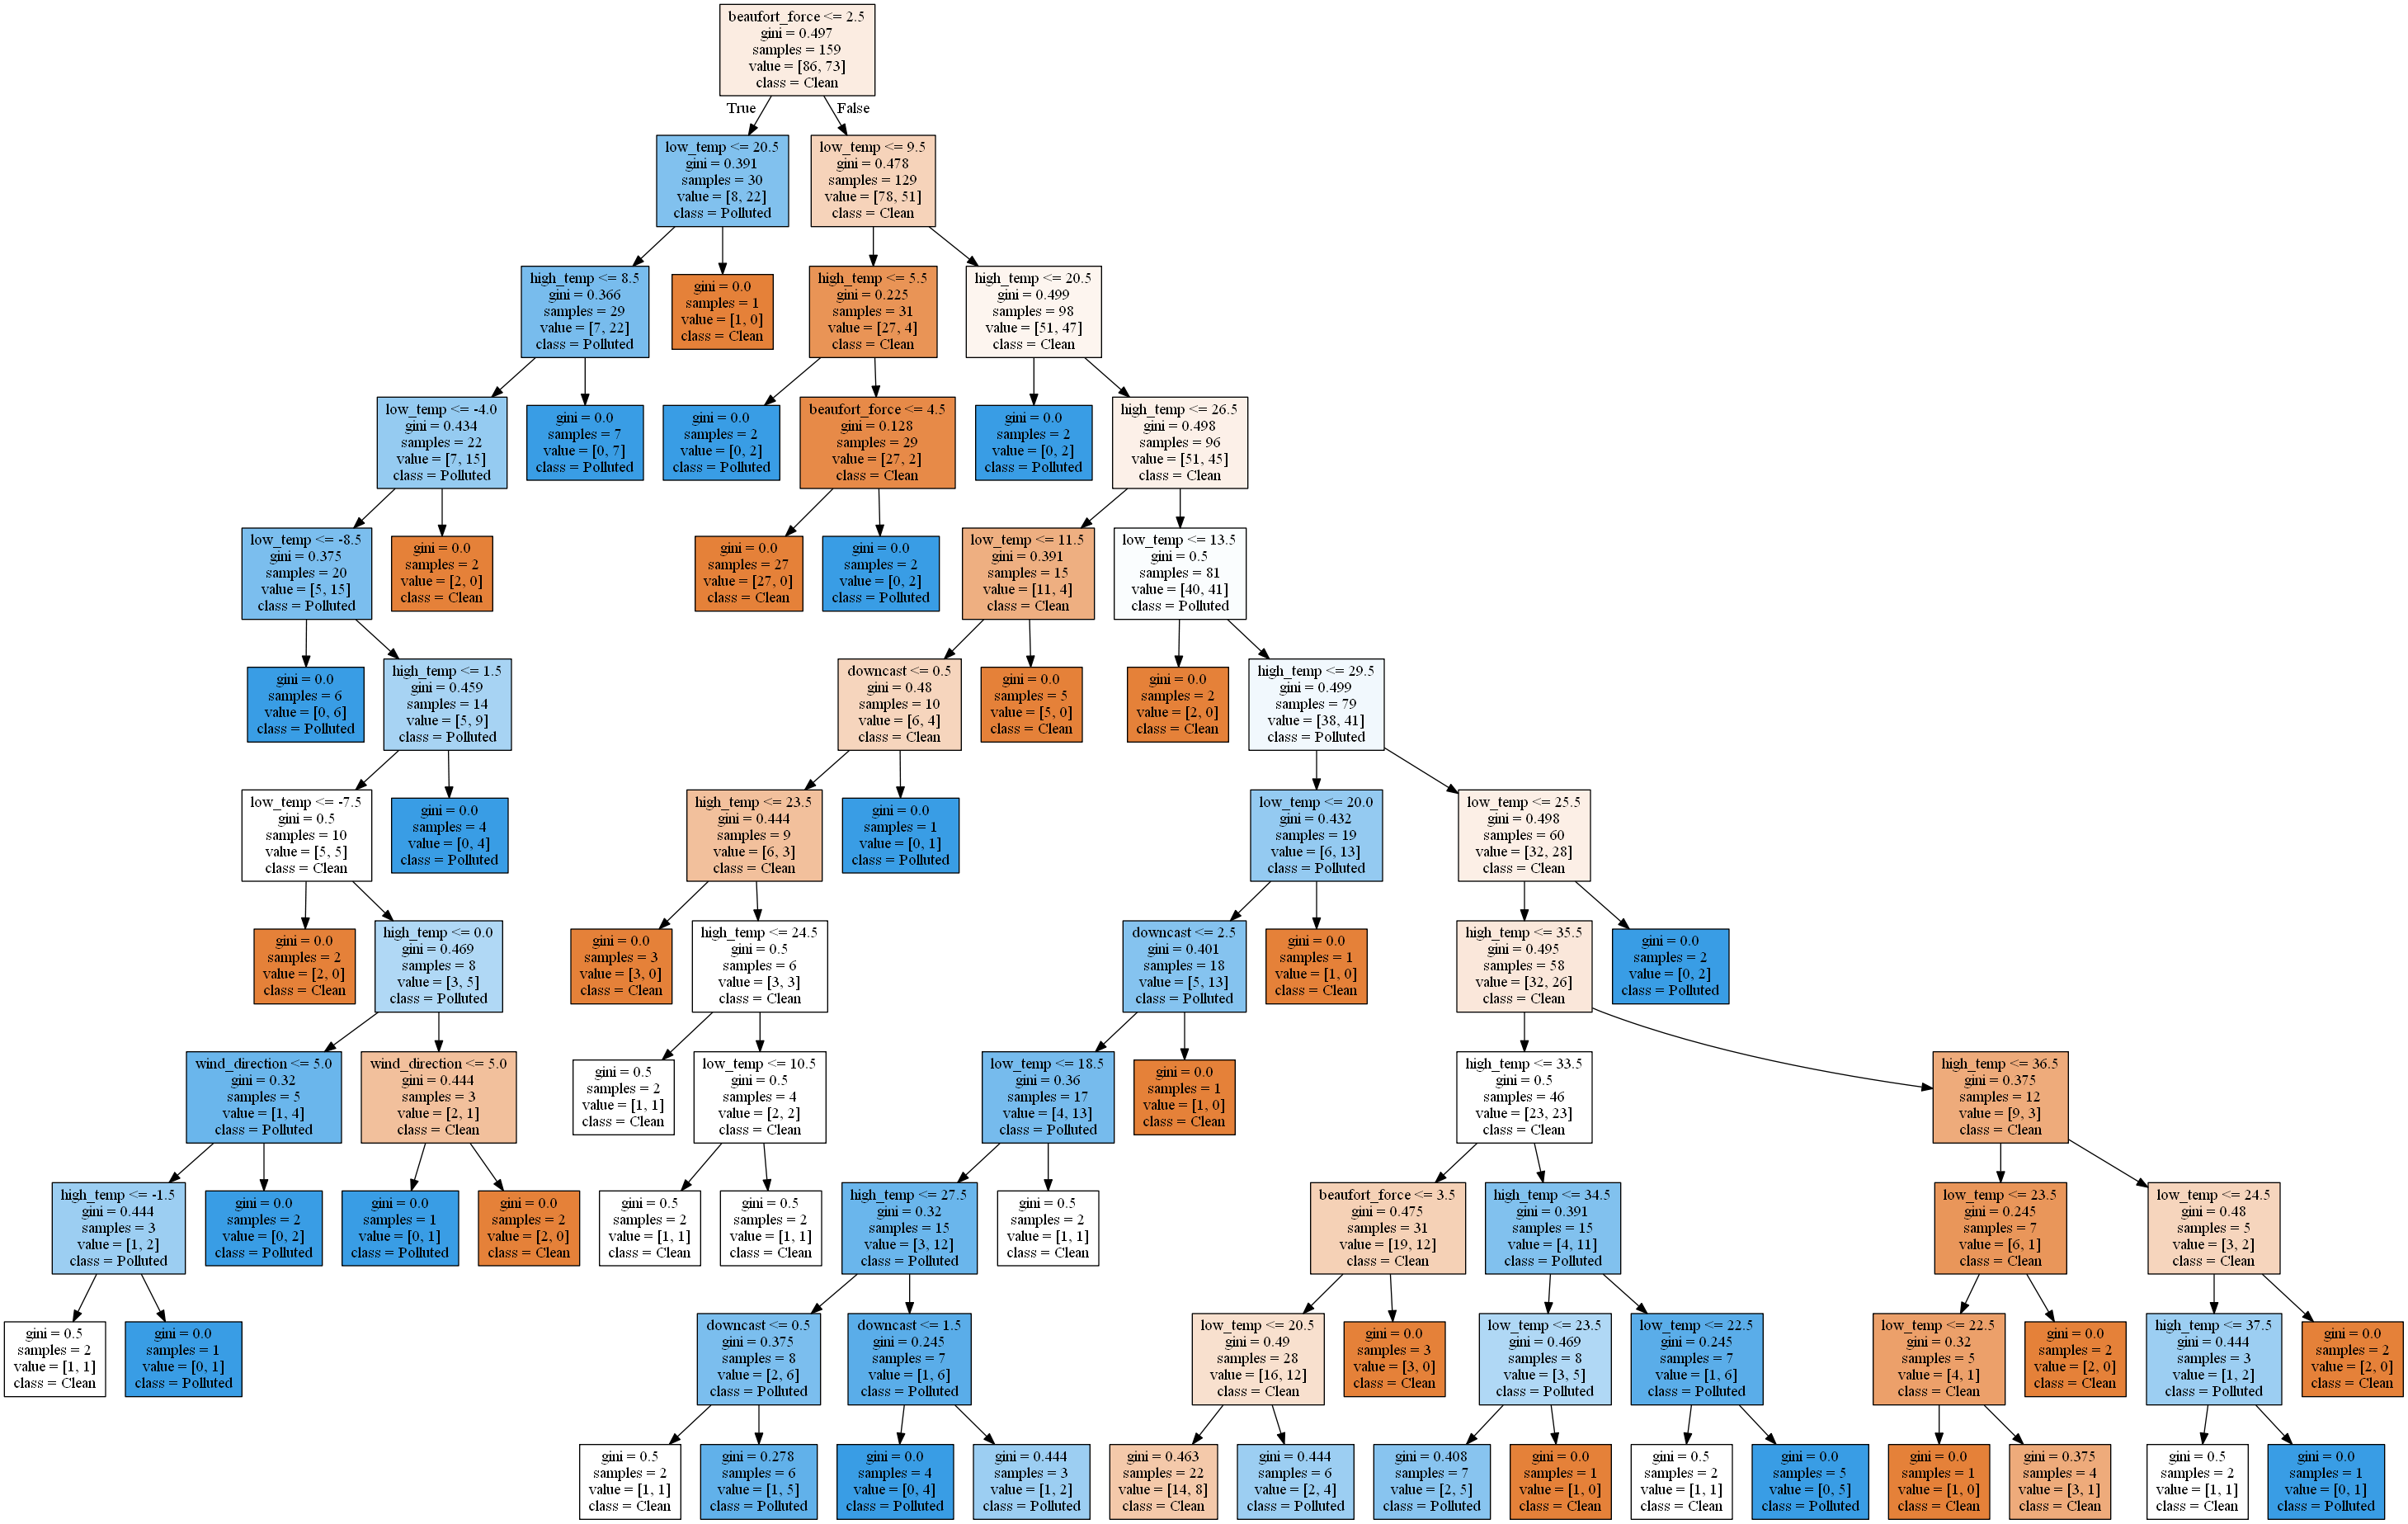

In [57]:
from IPython.display import Image
Image(filename =  "tree2018.png")

In [74]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
TN = cm[0][0]
FN = cm[1][0]
FP = cm[0][1]
TP = cm[1][1]
print("The sensitivity is {0:.2f}".format(TP/(FN+TP)))
print("The specificity is {0:.2f}".format(TN/(TN+FP)))
print("The positive precision is {0:.2f}".format((TP/(TP+FP))))
print("The negative precision is {0:.2f}".format((TN/(TN+FN))))
print("The accuracy is {0:.2f}".format((TP+TN)/(TP+TN+FP+FN)))

The sensitivity is 0.59
The specificity is 0.88
The positive precision is 0.85
The negative precision is 0.64
The accuracy is 0.72


The decision tree classifies based on lowest temperature and highest temperature, which are both ambeiguous. For clearlity, consider using the daily temperature range ΔTemp.

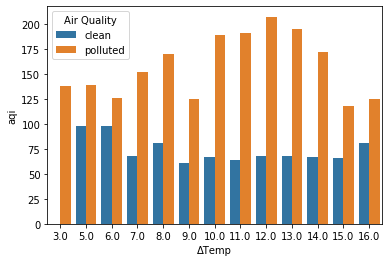

In [59]:
import seaborn as sns
np.random.seed(12345)
#df2018['ΔTemp']=df2018['ΔTemp'].astype(float)
#df2018['aqi']=df2018['aqi'].astype(float)
bplot = sns.barplot(x='ΔTemp',y='aqi',data=df2018,hue='health_index', ci=None)
plt.legend(title='Air Quality',loc='upper left', labels=['clean','polluted'])
plt.show(bplot)

The daily temperature difference doesn't appear to have a clear indication of AQI for both clean and polluted air.

In [60]:
feature_ncols = ['ΔTemp','beaufort_force','downcast','wind_direction']
xn = df2018.loc[:,feature_ncols]
yn = df2018['health_index']

xn_train, xn_test, yn_train, yn_test = train_test_split(xn, yn, test_size = 0.25, random_state = 42)
accuracyn_list = get_DecisionTreeClassifier(20, xn_train, yn_train, xn_test, yn_test)
for i in range(len(accuracyn_list)):
    print("{} {}".format(i+1,accuracyn_list[i]))

1 0.660377358490566
2 0.660377358490566
3 0.5471698113207547
4 0.5660377358490566
5 0.5660377358490566
6 0.5471698113207547
7 0.5849056603773585
8 0.5471698113207547
9 0.5471698113207547
10 0.5471698113207547
11 0.5471698113207547
12 0.5471698113207547
13 0.5471698113207547
14 0.5471698113207547
15 0.5471698113207547
16 0.5471698113207547
17 0.5471698113207547
18 0.5471698113207547
19 0.5471698113207547


The accuracy values peak around 7 and become consistent after 8, meaning that the tree has reached maximum depth and stopped growing.

In [61]:
clfn = DecisionTreeClassifier(max_depth = 7, random_state = 42)
clfn.fit(xn_train, yn_train)
predictionsn = clfn.predict(xn_test)
scoren = clfn.score(xn_test, yn_test)

from sklearn import tree
tree.export_graphviz(clfn,
                     out_file="tree2018n.dot",
                     feature_names=feature_ncols,
                     class_names=['Clean','Polluted'], 
                     rotate = False,
                     filled = True)

In [62]:
!"C:\Program Files (x86)\Graphviz2.38\bin\dot.exe" -Tpng tree2018n.dot -o tree2018n.png

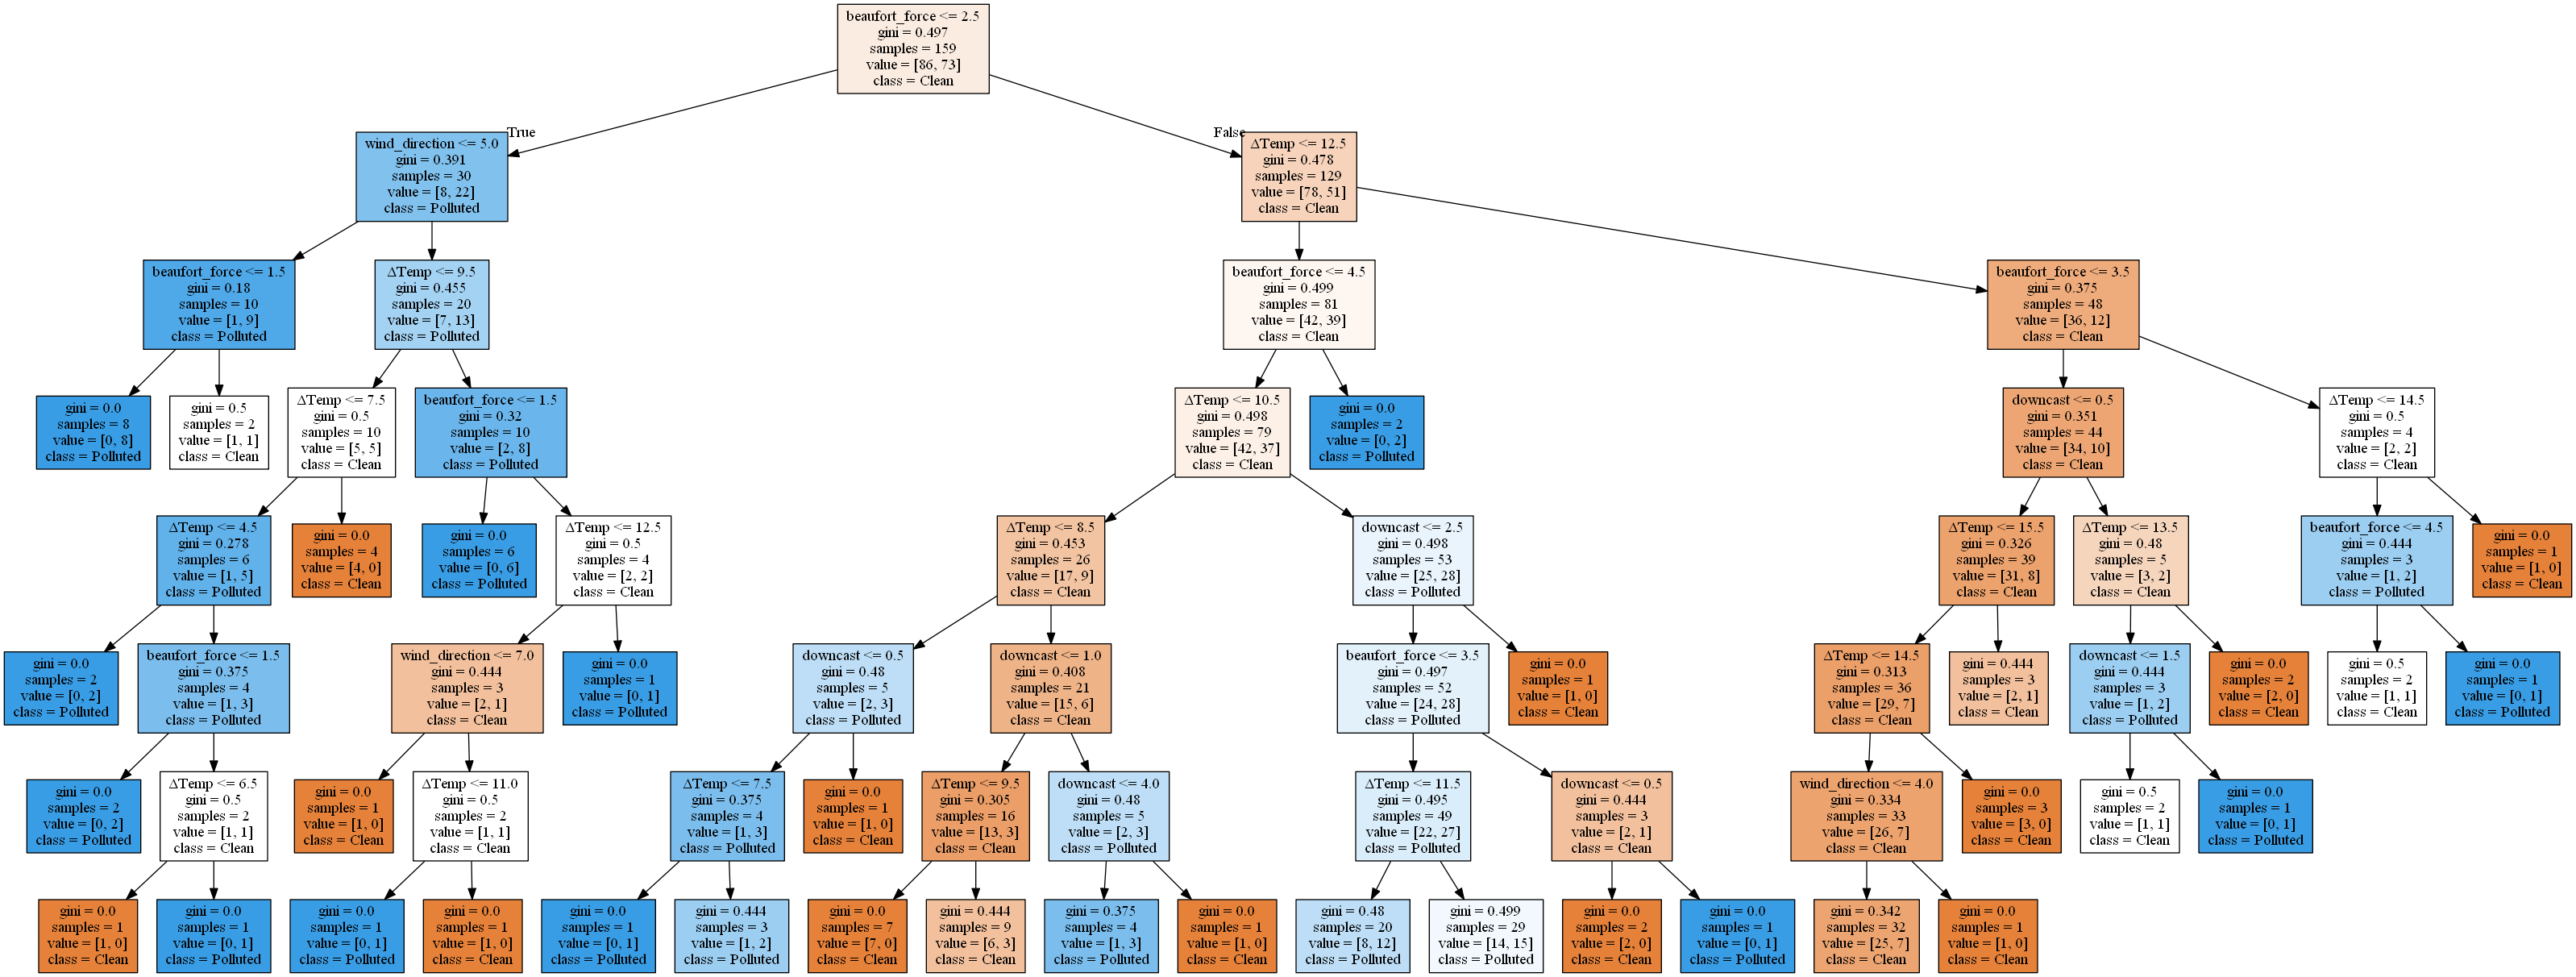

In [63]:
from IPython.display import Image
Image(filename =  "tree2018n.png")

In [75]:
from sklearn import metrics
cmn = metrics.confusion_matrix(yn_test, predictionsn)
TNn = cmn[0][0]
FNn = cmn[1][0]
FPn = cmn[0][1]
TPn = cmn[1][1]
print("The sensitivity is {0:.2f}".format(TPn/(FNn+TPn)))
print("The specificity is {0:.2f}".format(TNn/(TNn+FPn)))
print("The positive precision is {0:.2f}".format((TPn/(TPn+FPn))))
print("The negative precision is {0:.2f}".format((TNn/(TNn+FNn))))
print("The accuracy is {0:.2f}".format((TPn+TNn)/(TPn+TNn+FPn+FNn)))

The sensitivity is 0.55
The specificity is 0.62
The positive precision is 0.64
The negative precision is 0.54
The accuracy is 0.58


## Feature Importance
Retaining the original highest and lowest temperature column

In [65]:
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
low_temp,0.387
high_temp,0.328
beaufort_force,0.203
downcast,0.052
wind_direction,0.032


Use ΔTemp daily temperature range instead of high_temp and low_temp

In [66]:
importancesn = pd.DataFrame({'feature':xn_train.columns,'importance':np.round(clfn.feature_importances_,3)})
importancesn = importancesn.sort_values('importance',ascending=False).set_index('feature')
importancesn

,importance
feature,
ΔTemp,0.474
beaufort_force,0.315
downcast,0.173
wind_direction,0.038


Try to use linear regression and polynomial to understand the relation between aqi and ΔTemp daily temperature flatuations.

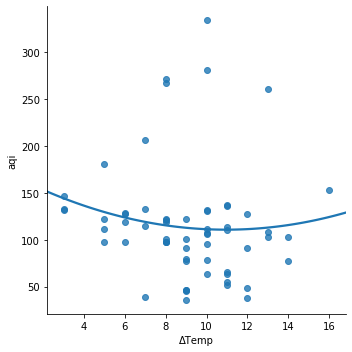

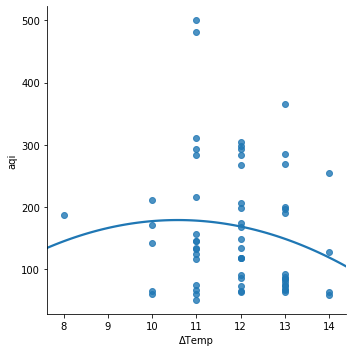

In [67]:
import seaborn as sns
# dataframe for December and November
df_w11 = df2018.loc[df2018['month']=='201811'].reset_index()
df_w12 = df2018.loc[df2018['month']=='201812'].reset_index()
df_w = pd.concat([df_w11,df_w12])
lplot1 = sns.lmplot(x='ΔTemp',y='aqi',data=df_w, ci=None, order=2)

# dataframe for July and August
df_s07 = df2018.loc[df2018['month']=='201807'].reset_index()
df_s08 = df2018.loc[df2018['month']=='201808'].reset_index()
df_s = pd.concat([df_s07,df_s08])
lplot2 = sns.lmplot(x='ΔTemp',y='aqi',data=df_s,ci=None, order=2)
plt.show(lplot1,lplot2)

AQI and ΔTemp daily temperature flatuations for summer months July and August.

The score of regression model is 0.026


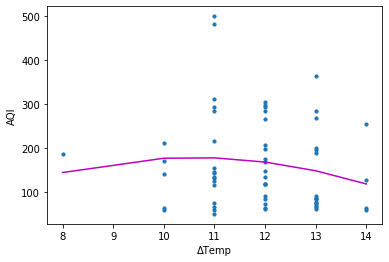

In [68]:
import operator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

xs = df_s['ΔTemp'].values
xs = xs.reshape(62,1)
ys = df_s['aqi'].values
ys = ys.reshape(62,)

#xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size = 0.25, random_state = 42)

polynomial_features = PolynomialFeatures(degree=2)

xs_poly = polynomial_features.fit_transform(xs)
#xs_poly_train = polynomial_features.fit_transform(xs_train)

model = LinearRegression(fit_intercept=True)
model.fit(xs_poly, ys)

predictionss = model.predict(xs_poly)
plt.scatter(xs,ys,s=10)

scores = model.score(xs_poly, ys)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(xs,predictionss),key=sort_axis)
xs_poly,predictionss = zip(*sorted_zip)
plt.plot(xs_poly, predictionss, color='m')
plt.xlabel('ΔTemp')
plt.ylabel('AQI')

print("The score of regression model is {0:.3f}".format(scores))

AQI and ΔTemp daily temperature flatuations for winter months November and December.

The score of regression model is 0.077


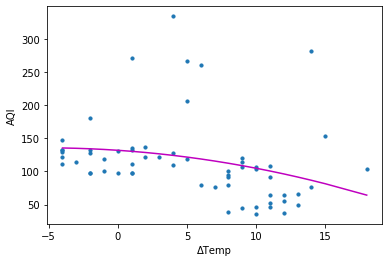

In [69]:
xw = df_w['high_temp'].values
xw = xw.reshape(61,1)
yw = df_w['aqi'].values
yw = yw.reshape(61,)

#xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size = 0.25, random_state = 42)

polynomial_features = PolynomialFeatures(degree=2)

xw_poly = polynomial_features.fit_transform(xw)
#xs_poly_train = polynomial_features.fit_transform(xs_train)

model = LinearRegression(fit_intercept=True)
model.fit(xw_poly, yw)

predictionss = model.predict(xw_poly)
plt.scatter(xw,yw,s=10)

scorew = model.score(xw_poly, yw)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(xw,predictionss),key=sort_axis)
xw_poly,predictionss = zip(*sorted_zip)
plt.plot(xw_poly, predictionss, color='m')
plt.xlabel('ΔTemp')
plt.ylabel('AQI')

print("The score of regression model is {0:.3f}".format(scorew))

# Conclusion
Use decision tree to model the AQI values in relation with other meteorological data gathered from the weather forecast website. The feature importance reveals that beaufort force, highest and lowest temperature are important to determining air quality being polluted or clean, above or below 100 AQI. 
Beaufort force signifies the incoming winds, regardless of direction, have the significant impact around 0.20 and 0.30 of feature importance for classifiying clean and polluted AQI. Beaufort level greater than or equal to level 2.5 is the first node to distinguish clean from polluted, which signifies that light and gentle breeze (beaufort force level 2 and 3) have positive impact in air quality.

As we travel down the tree, temperature starts to take part in decision-making. Around 0.40 and 0.32 of feature importance for lowest and highest temperature, respectively. The difference ΔTemp takes more importance at 0.47.

The decision tree with highest and lowest temperature values has a sensitivity rate of 0.59 and a specificity rate of 0.88. To observe the AQI classification in term of daily temperature fluctuation, highest and lowest are subtracted to find the fluctuation range values in the new column ΔTemp. The resulting decision tree has sensitivity and specificity rate lowered to 0.55 and 0.62, respectively.
This lowered sensitivity and specificity rate suggests that clean and polluted AQI classification does not have a trend relying on the daily temperature range. It is perhaps more dependable on long-term temperature changes ranging across days and months, long enough to be distinguished as cold or warm season.

AQI level reached maximum in August and December, 2018 when there were significant increase and decrease of temperature, respectively. 
However, the linear modified with polynomial regressions score too low to ensure reliable predictions, 0.026 and 0.077 for warm and cold season (July to August and November to December, 2018).

When viewing the mean values of the highest and lowest temperature from June to December, there is a trend of high temperatures from 31.9 to 32.3 ℃ for the mean highest temperature and around 20℃ for the mean lowest temperature. A decreasing trend of high and low temperature toward December, from 9.7 and -0.4 in November to 0.7 and -7.3 ℃ in December. The AQI levels also peaked in these two months 256 and 146 for August and December, respectively. 

Complying with the observations recorded by Ikram et al., a decrease in temperature in cold season results in the increase in AQI. As for a small increase in temperature, a larger increase of AQI is observed in warm season compared with cold season (Ikram et al., 2015). Therefore, AQI is suspectable to increase when temperature values increase before and during August in the warm season. When the temperature values decrease toward December in cold season, AQI is suspectable to increase again.

## Resource
Ikram, Maria, et al. "Seasonal effects of temperature fluctuations on air quality and respiratory disease: a study in Beijing." Natural Hazards 79.2 (2015): 833-853.